## Multicollinearity - detection and remedies

- https://www.kaggle.com/code/marcinrutecki/multicollinearity-detection-and-remedies

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

### 1. Introduction

공선형성(및 다중공선형성)은 독립 변수라고도 하는 예측 변수들이 서로 독립적이지 않다는 것을 의미합니다.  

상관관계는 두 특징이 선형적으로 연관되어 있는(상관관계가 높은) 상황을 말하며, 이를 대상에 대한 예측 변수로 사용합니다.   
피어슨 상관 계수를 사용하여 측정하는 경우가 많습니다.   
두 개 이상의 예측자 간의 상관관계도 가능하며, 실제로도 종종 발생합니다.

다중 상관성이라는 용어는 라그나 프리쉬가 처음 사용했습니다.  
다중 선형성은 하나의 특징이 두 개 이상의 특징과 선형 관계를 나타내는 선형성의 특수한 경우입니다.  
또한 두 개 이상의 특징이 상관관계가 있으면서 동시에 쌍으로 높은 상관관계가 없는 상황도 있을 수 있습니다.

부분 다중공선성은 다중 회귀에서 흔히 볼 수 있는 현상입니다.  
두 개의 무작위 변수는 더 큰 모집단에서 근본적인 관계를 공유하지 않더라도 샘플에서 거의 항상 어느 수준에서 상관관계를 갖습니다.  
즉, 다중공선성은 정도의 문제입니다.

#### 1.1 Consequences of multicollinearity
다중공선성은 모델 피팅 중에 심각한 문제를 일으킬 수 있습니다.   
회귀 및 분류 모델의 전반적인 성능을 저하시킬 수 있습니다.  

- 편향을 증가시키지는 않지만 분산을 증가시킬 수 있습니다(과적합);
- 모델의 사소한 변경에 추정치가 매우 민감하게 반응합니다;
- 예측력에는 영향을 미치지 않지만 개별 예측 변수가 응답 변수에 미치는 영향이 잘못 계산될 수 있습니다.   

그 결과 계수 추정치가 불안정하고 해석하기 어렵습니다.   
다중공선성은 분석의 통계적 힘을 약화시키고 계수의 부호가 바뀔 수 있으며 올바른 모델을 지정하기가 더 어려워집니다.

#### 1.2 Remedies to multicollinearity problem

1. 샘플 크기를 늘립니다. 
   - 표본을 확대하면 데이터 계열에 더 많은 변동이 발생하여 샘플링 오류의 영향을 줄이고 데이터의 다양한 속성을 추정할 때 정밀도를 높이는 데 도움이 됩니다.  
   - 표본 크기를 늘리면 다중 공선성의 존재나 영향을 줄이거나 둘 다 줄일 수 있습니다.   
2. 상관관계가 높은 일부 특징을 제거합니다.  
   - 수동 방법 - 분산 인플레이션 계수(VIF)
   - 자동 방법 - 재귀적 특징 제거(RFE)
   - PCA 분해를 사용한 특징 제거(이 연구에서는 건너뛰겠습니다.)
3. 상관관계가 높은 회귀변수를 선형 조합으로 대체합니다.
4. 피처 엔지니어링에 관한 상식을 지키고 자신이 무엇을 하고 있는지 이해합니다.
5. RIDGE, LASSO 또는 베이지안 회귀와 같은 정규화 방법을 사용합니다.

### 2. Set-up

#### 2.1 Import Libraries

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

#### 2.2 Data Set Characteristics

boston housing  
- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per 10 000 USD
- PTRATIO pupil-teacher ratio by town
- B 1000 (Bk - 0.63)^2 where Bk is the proportion of black people by town
- LSTAT % lower status of the population
- MEDV Median value of owner-occupied homes in $1000's

BMI Dataset   
- Gender : Male / Female

- Height : Number (cm)

- Weight : Number (Kg)

Index:

0 - Extremely Weak

1 - Weak

2 - Normal

3 - Overweight

4 - Obesity

5 - Extreme Obesity

#### 2.3 Import Data

In [3]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
raw_boston = pd.read_csv("../data/boston_house_prices.csv")
raw_bmi = pd.read_csv("../data/bmi/bmi.csv")

In [4]:
# creating dummies for gender
raw_bmi['Gender'] = raw_bmi['Gender'].map({'Male':0, 'Female':1})

In [5]:
raw_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [6]:
raw_bmi.head()

,Gender,Height,Weight,Index
0,0,174,96,4
1,0,189,87,2
2,1,185,110,4
3,1,195,104,3
4,0,149,61,3


### 3. The correlation matrix

상관관계 행렬은 두 독립 변수 간의 쌍별 상관관계 또는 이변량 관계, 즉 상관성을 제공합니다.  
서로 다른 변수에 대한 상관 계수를 표시하는 표입니다.  
숫자 열이 있는 입력 관계를 받아 입력 열의 각 쌍 사이의 피어슨 상관계수를 계산합니다.

이 행렬은 테이블에서 가능한 모든 값 쌍 간의 상관관계를 보여줍니다.  
대규모 데이터 세트를 요약하고 주어진 데이터에서 패턴을 식별하고 시각화할 수 있는 강력한 도구입니다.  
상관관계 행렬에 절대값이 높은 요소가 나타나면 상관관계에 대해 이야기할 수 있습니다.  
극단적으로 설명 변수가 완전히 겹치는 경우입니다.

Text(0.5, 1.0, 'BMI Correlation Heatmap')

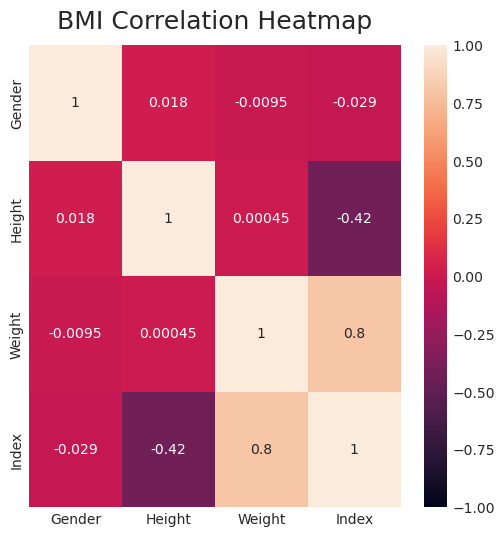

In [7]:
### Plotting the correlation between various columns
plt.figure(figsize = (6, 6))
heatmap = sns.heatmap(raw_bmi.corr(), vmin = -1, vmax = 1, annot = True)
heatmap.set_title('BMI Correlation Heatmap', fontdict = {'fontsize' : 18}, pad = 12)

- 예상대로 Index가 weight, Height와 상관도가 높다.  
- 그리고 weight가 index에 미치는 영향이 더 크다.  
- 우리를 직관에 의해 안다. 이를 도메인 지식이라고 한다.

Text(0.5, 1.0, 'Boston Correlation Heatmap')

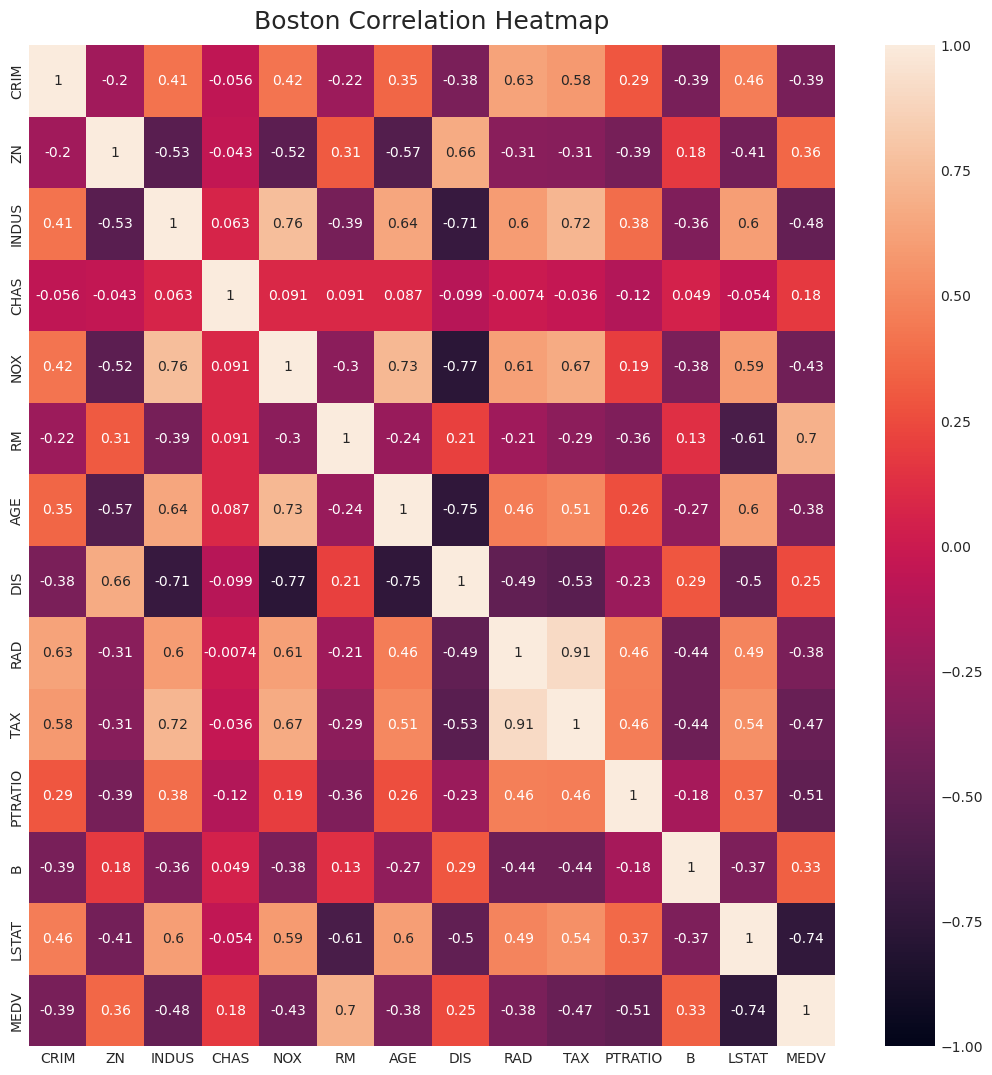

In [8]:
### Plotting the correlation between various columns
plt.figure(figsize = (13, 13))
heatmap = sns.heatmap(raw_boston.corr(), vmin = -1, vmax = 1, annot = True)
heatmap.set_title('Boston Correlation Heatmap', fontdict = {'fontsize' : 18}, pad = 12)

#### 3.1 Clustermap

클러스터맵 테이블은 변수 간의 모든 상관관계뿐만 아니라 그룹(클러스터) 관계도 보여줍니다.

<Figure size 400x400 with 0 Axes>

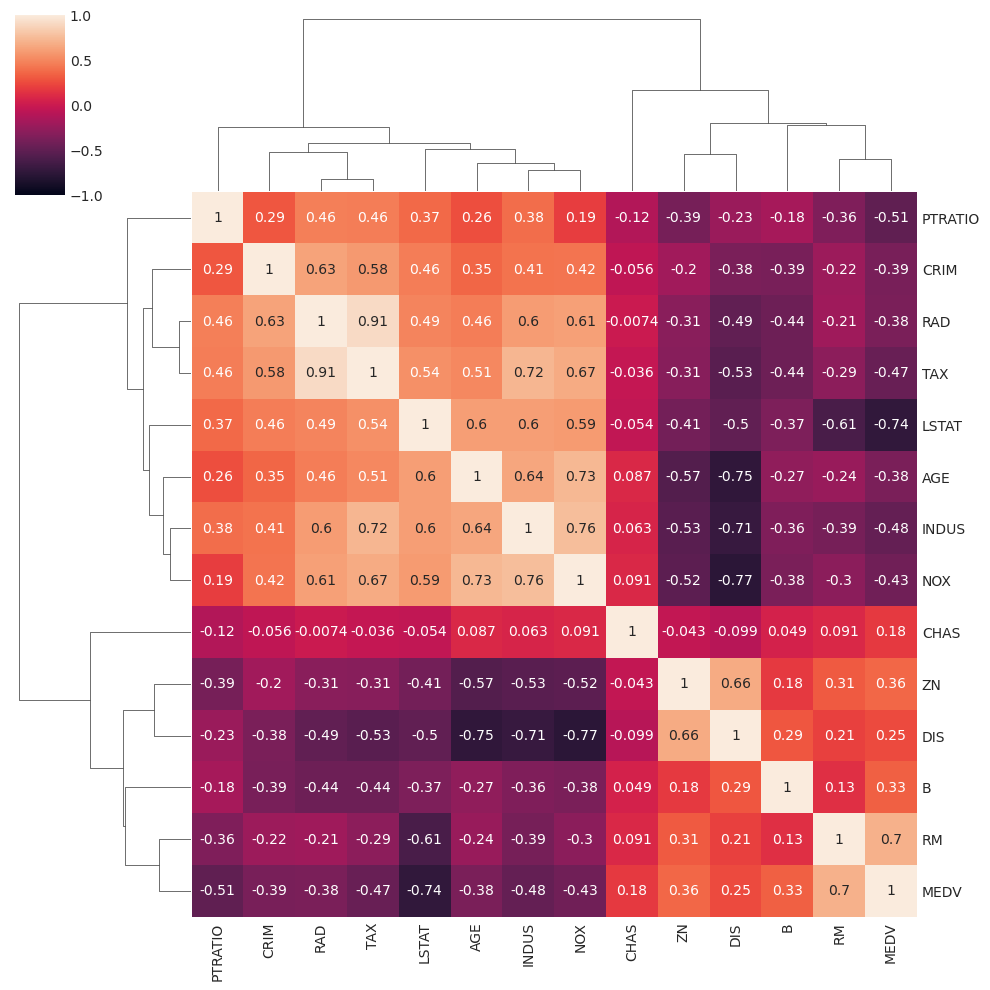

In [9]:
plt.figure(figsize = (4, 4))
clustermap = sns.clustermap(raw_boston.corr(), vmin = -1, vmax = 1, annot = True)

 인플레이션 계수(VIF)는 회귀 분석에서 다중공선성의 정도를 측정하는 척도입니다.   
 VIF는 하나의 독립 변수와 다른 변수 그룹 간의 상관 관계를 식별하는 데 사용됩니다.

VIF_i = 1 / (1-R_i^2)

회귀 분석에서 다중공선성은 두 개 이상의 변수가 선형 관계를 보일 때 존재합니다.   
VIF는 특정 회귀변수와 다른 회귀변수의 선형 상관관계가 상관관계가 없는 기준 사례와 비교하여 계수 추정치의 분산을 얼마나 증가시키는지를 측정합니다.   

VIF는 예측자 간의 상관관계가 분산을 부풀리는 요인을 알려줍니다.  
예를 들어, VIF가 10이면 기존의 다중공선성이 다중공선성이 없는 모델에 비해 계수의 분산을 10배 부풀리고 있음을 나타냅니다.   

VIF에는 상한이 없습니다. 값이 낮을수록 좋습니다.  
4 또는 5 이상의 값은 보통에서 높은 값으로 간주되며, 10 이상의 값은 매우 높은 값으로 간주됩니다.   

따라서 VIF = 5를 임계값으로 사용하는 경우가 많습니다.   
즉, 5보다 큰 독립 변수는 모두 제거해야 합니다.  
이상적인 임계값은 사례에 따라 다릅니다.  
많은 계량경제학 교과서에서 다중공선성은 VIF가 10을 초과하는 경우에만 심각한 것으로 간주됩니다.

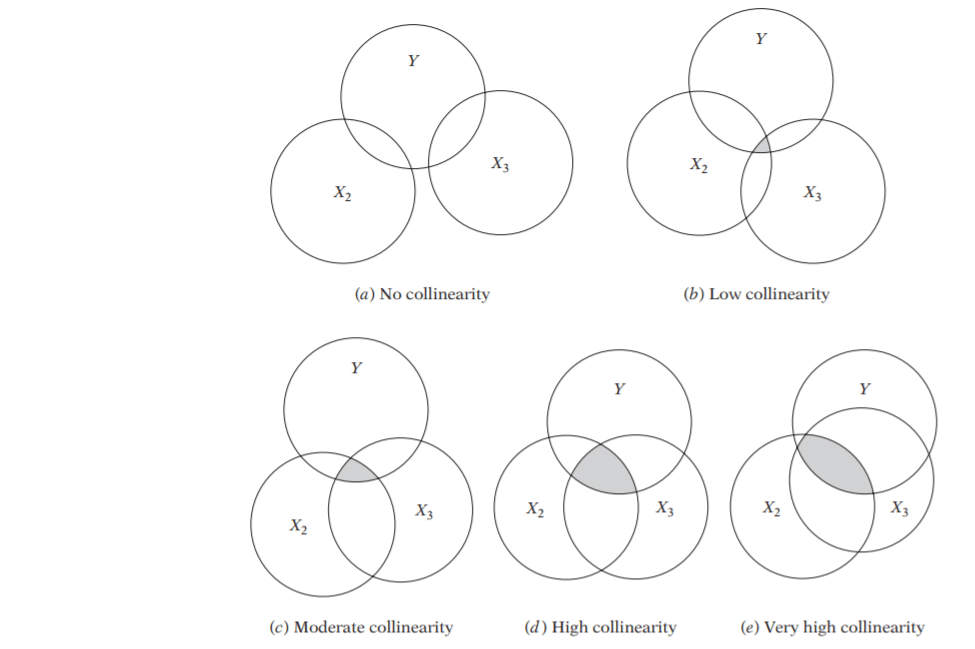

#### 4.1 Two kinds of multicollinearity 

1. 데이터 기반 다중공선성: 이러한 유형의 다중공선성은 데이터 자체에 존재합니다. 관찰 실험은 이러한 종류의 다중공선성을 나타낼 가능성이 높습니다.
- 예: 두 개의 동일한(또는 거의 동일한) 변수가 있습니다. 파운드 단위의 체중과 킬로 단위의 체중, 또는 투자 소득과 저축/채권 소득.  

2. 구조적 다중공선성: 연구자가 새로운 예측 변수를 생성하여 발생합니다. 이 유형은 다른 용어를 사용하여 모델 용어를 만들 때 발생합니다. 즉, 우리가 지정한 모델의 부산물입니다.
실제로는 다른 두 변수의 조합인 변수를 회귀에 포함시키는 경우입니다. 
- 예를 들어, 총 투자 소득 = 주식 및 채권 소득 + 예금 이자 소득인 경우 '총 투자 소득'을 포함하는 것입니다.

#### 4.2 Data-based multicollinearity

In [10]:
# the independent variables set
X = raw_bmi[['Gender', 'Height', 'Weight']]

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns

vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,Feature,VIF
0,Gender,2.028864
1,Height,11.623103
2,Weight,10.688377


'키'와 '몸무게'의 VIF 값이 높다는 것은 이 두 변수가 높은 상관관계를 가지고 있음을 나타냅니다. 이는 사람의 키가 체중에 영향을 미치기 때문에 예상되는 결과입니다. 따라서 이 두 가지 특징을 함께 고려해도 여전히 높은 다중공선성을 가진 모델이 생성됩니다.

#### 4.3 Structural multicollinearity
이제  'Gender', 'Height', 'Weight' and 'Index 네가지를 고려해서 구해보자.

In [11]:
# the independent variables set
X = raw_bmi[['Gender', 'Height', 'Weight', 'Index']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

  Feature        VIF
0  Gender   2.031010
1  Height  11.941301
2  Weight  40.024880
3   Index  25.143752


상당한 차이가 있습니다!  
'Weight'의 VIF는 40을 초과하고 'Index'의 VIF는 25를 초과합니다!

데이터 집합에서 'Index'를 사용할 수 있다는 것은 알지만, 'Index'가 실제로 무엇을 의미하는지 잠시 생각해 보십시오.  
다른 피처의 파생물로 취급할 수 있습니다. 피처 엔지니어링 중에 이러한 새로운 피처를 만드는 것은 매우 일반적입니다.

어쨌든, 우리는 이것을 한 연구원이 만든 다중연관성의 좋은 예로 삼을 수 있습니다.

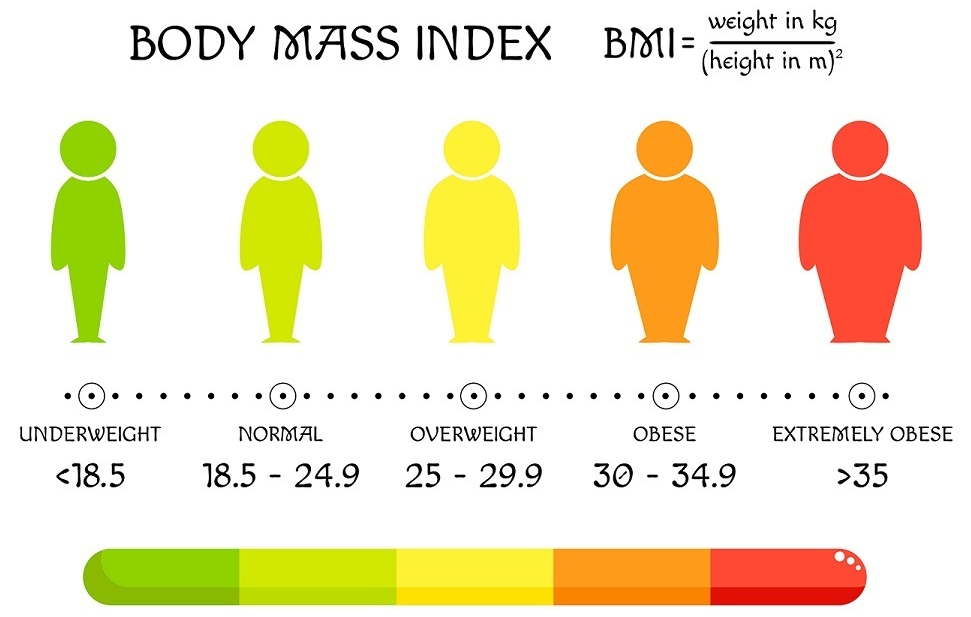

### 5. Feature reduction based on VIF

보스톤 데이터셋을 살펴보자.

In [12]:
# the independent variables set
X2 = raw_boston[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
  
# VIF dataframe
vif2_data = pd.DataFrame()
vif2_data["Feature"] = X2.columns
  
# calculating VIF for each feature
vif2_data["VIF"] = [variance_inflation_factor(X2.values, i)
                          for i in range(len(X2.columns))]
  
print(vif2_data)

    Feature        VIF
0      CRIM   2.100373
1        ZN   2.844013
2     INDUS  14.485758
3      CHAS   1.152952
4       NOX  73.894947
5        RM  77.948283
6       AGE  21.386850
7       DIS  14.699652
8       RAD  15.167725
9       TAX  61.227274
10  PTRATIO  85.029547
11        B  20.104943
12    LSTAT  11.102025


피처를 제거하면서 구해보자.  
- 주의사항 : 반드시 하나씩 제거하면서 계산해봐야 한다.

값이 가장큰 PTRATIO를 제거해보자.

In [13]:
# the independent variables set
X2 = raw_boston[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'B', 'LSTAT']]
  
# VIF dataframe
vif2_data = pd.DataFrame()
vif2_data["Feature"] = X2.columns
  
# calculating VIF for each feature
vif2_data["VIF"] = [variance_inflation_factor(X2.values, i)
                          for i in range(len(X2.columns))]

print(vif2_data)

   Feature        VIF
0     CRIM   2.099345
1       ZN   2.451624
2    INDUS  14.275283
3     CHAS   1.142167
4      NOX  73.894171
5       RM  60.598846
6      AGE  21.361234
7      DIS  12.221605
8      RAD  15.159162
9      TAX  59.301541
10       B  18.614751
11   LSTAT  10.138324


이 같은 과정을 반복해보자. 10 이하의 피처만 남을때까지 반복하자.

In [14]:
# the independent variables set
X2 = raw_boston[['CRIM', 'ZN', 'INDUS', 'CHAS', 'DIS', 'RAD', 'LSTAT']]
  
# VIF dataframe
vif2_data = pd.DataFrame()
vif2_data["Feature"] = X2.columns
  
# calculating VIF for each feature
vif2_data["VIF"] = [variance_inflation_factor(X2.values, i)
                          for i in range(len(X2.columns))]

print(vif2_data)

  Feature       VIF
0    CRIM  2.067135
1      ZN  2.299351
2   INDUS  6.900077
3    CHAS  1.086574
4     DIS  3.968908
5     RAD  4.678181
6   LSTAT  6.726973


### 6. Regression Models performance comparison
#### 6.1 Some data pre-processing

In [15]:
scaled_boston = raw_boston.copy()

In [16]:
from sklearn.preprocessing import StandardScaler

col_names = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
features = scaled_boston[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_boston[col_names] = features
scaled_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.419782,0.284830,-1.287909,0,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,0,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,0,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,0,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,0,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [17]:
X = scaled_boston.iloc[:, :-1].values
y = scaled_boston.iloc[:, -1].values

### 7. Linear Regression

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [19]:
from sklearn.linear_model import LinearRegression

# Creating and training model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = lm.predict(X_test)

In [20]:
# Predicting Cross Validation Score
cv_lm = cross_val_score(estimator = lm, X = X_train, y = y_train, cv = 10)

# Calculating Adjusted R-squared
r2 = lm.score(X_test, y_test)
# Number of observations is the shape along axis 0
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# Adjusted R-squared formula
lm_adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
lm_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
lm_R2 = lm.score(X_test, y_test)
lmCV_R2 = cv_lm.mean()

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4) )
print('R2:', round( lm.score(X_test, y_test),4) )
print('Adjusted R2:', round(lm_adjusted_r2, 4) )
print("Cross Validated R2: ", round( cv_lm.mean(),4) )

RMSE: 4.6387
R2: 0.7112
Adjusted R2: 0.684
Cross Validated R2:  0.6875


Text(0.5, 1.0, 'Linear regression with all features')

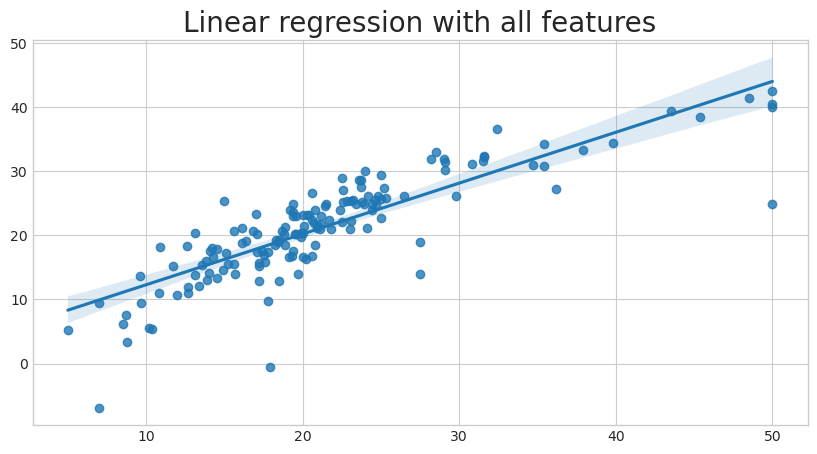

In [21]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Linear regression with all features', fontsize = 20)

### 8. Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Creating and training model
RandomForest_reg = RandomForestRegressor(n_estimators = 10, random_state = 0)
RandomForest_reg.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = RandomForest_reg.predict(X_test)

In [23]:
# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = RandomForest_reg, X = X_train, y = y_train, cv = 10)

# Calculating Adjusted R-squared
r2 = RandomForest_reg.score(X_test, y_test)
# Number of observations is the shape along axis 0
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# Adjusted R-squared formula
rf_adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
rf_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rf_R2 = RandomForest_reg.score(X_test, y_test)
rfCV_R2 = cv_rf.mean()

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4) )
print('R2:', round( RandomForest_reg.score(X_test, y_test),4) )
print('Adjusted R2:', round(rf_adjusted_r2, 4) )
print("Cross Validated R2: ", round( cv_rf.mean(),4) )

RMSE: 3.3291
R2: 0.8513
Adjusted R2: 0.8373
Cross Validated R2:  0.8171


- Results from Random Forest model looks much better!

### 9. Linear Regressin after droping features using VIF

In [24]:
scaled_boston2 = scaled_boston.copy()

scaled_boston2 = scaled_boston2.drop(['NOX', 'RM', 'AGE', 'TAX', 'PTRATIO', 'B'], axis=1)

In [25]:
X = scaled_boston2.iloc[:, :-1].values
y = scaled_boston2.iloc[:, -1].values

In [26]:
scaled_boston2.head()

,CRIM,ZN,INDUS,CHAS,DIS,RAD,LSTAT,MEDV
0,-0.419782,0.284830,-1.287909,0,0.140214,-0.982843,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,0,0.557160,-0.867883,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,0,0.557160,-0.867883,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,0,1.077737,-0.752922,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,0,1.077737,-0.752922,-1.026501,36.2


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [28]:
lm2 = LinearRegression()
lm2.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = lm2.predict(X_test)

Text(0.5, 1.0, 'Linear regression after dropping features')

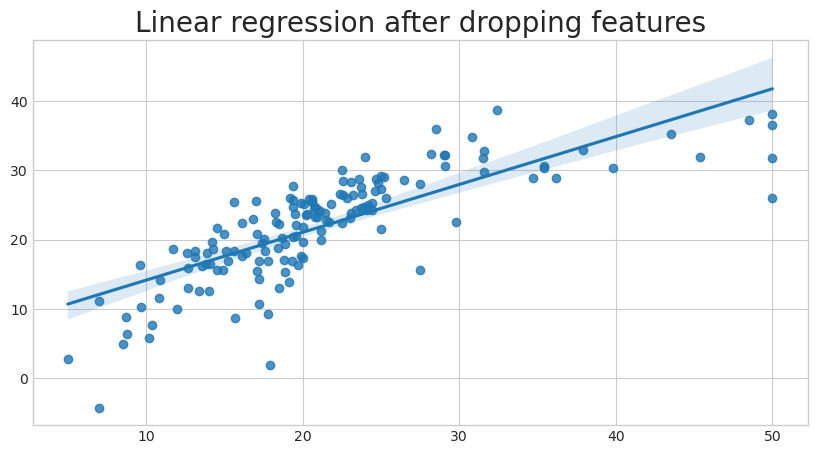

In [29]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Linear regression after dropping features', fontsize = 20)

In [30]:
# Predicting Cross Validation Score
cv_lm2 = cross_val_score(estimator = lm2, X = X_train, y = y_train, cv = 10)

# Calculating Adjusted R-squared
r2 = lm2.score(X_test, y_test)
# Number of observations is the shape along axis 0
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# Adjusted R-squared formula
lm2_adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
lm2_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
lm2_R2 = lm2.score(X_test, y_test)
lm2CV_R2 = cv_lm2.mean()

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4) )
print('R2:', round( lm2.score(X_test, y_test),4) )
print('Adjusted R2:', round(lm2_adjusted_r2, 4) )
print("Cross Validated R2: ", round( cv_lm2.mean(),4) )

RMSE: 5.4573
R2: 0.6003
Adjusted R2: 0.5809
Cross Validated R2:  0.606


- 결과가 좋아지지는 않았다.

### 10. Random Forest model after droping features using VIF

In [31]:
# Creating and training model
RandomForest2_reg = RandomForestRegressor(n_estimators = 10, random_state = 0)
RandomForest2_reg.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = RandomForest2_reg.predict(X_test)

In [32]:
# Predicting Cross Validation Score
cv_rf2 = cross_val_score(estimator = RandomForest2_reg, X = X_train, y = y_train, cv = 10)

# Calculating Adjusted R-squared
r2 = RandomForest2_reg.score(X_test, y_test)
# Number of observations is the shape along axis 0
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# Adjusted R-squared formula
rf2_adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
rf2_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rf2_R2 = RandomForest2_reg.score(X_test, y_test)
rf2CV_R2 = cv_rf2.mean()

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4) )
print('R2:', round( RandomForest2_reg.score(X_test, y_test),4) )
print('Adjusted R2:', round(rf2_adjusted_r2, 4) )
print("Cross Validated R2: ", round( cv_rf2.mean(),4) )

RMSE: 4.4068
R2: 0.7394
Adjusted R2: 0.7267
Cross Validated R2:  0.7554


- 역시 droping하고 성능이 더 떨어졌다.

### 11. Recursive Feature Elimination (RFE)

재귀적 특징 제거(RFE)는 역방향 특징 선택 알고리즘입니다.  

이 알고리즘은 모델을 여러 번 피팅하고 각 단계마다 피팅된 모델의 coef_ 또는 featureimportances 속성에 따라 결정되는 가장 약한 피처를 제거하여 모델에서 n개의 피처를 제거합니다.  

RFE는 훈련 데이터 세트의 모든 특징부터 시작하여 원하는 개수가 남을 때까지 특징을 성공적으로 제거하여 특징의 하위 집합을 검색하는 방식으로 작동합니다.  

RFE는 래퍼형 특징 선택 알고리즘입니다. 즉, 방법의 핵심에 다른 머신러닝 알고리즘이 제공되어 사용되며, RFE로 래핑되어 피처를 선택하는 데 사용됩니다.   

모든 모델이 RFE 방법과 짝을 이룰 수 있는 것은 아니며, 일부 모델은 다른 모델보다 RFE의 이점을 더 많이 누릴 수 있습니다.  
RFE는 초기 모델에 전체 예측자 집합을 사용해야 하므로 예측자 수가 샘플 수를 초과하는 경우 일부 모델을 사용할 수 없습니다.  
이러한 모델에는 다중 선형 회귀, 로지스틱 회귀 및 선형 판별 분석이 포함됩니다.  
RFE에 이러한 기법 중 하나를 사용하려면 먼저 예측자의 수를 줄여야 합니다.  
또한 일부 모델은 다른 모델보다 RFE를 사용하면 더 많은 이점을 얻을 수 있습니다. 랜덤 포레스트가 그러한 모델 중 하나입니다(Svetnik 외. 2003).   

무작위 포리스트 모델에서 역선택이 자주 사용되는 이유는 두 가지입니다:

- 랜덤 포레스트는 예측 방정식에서 변수를 제외하지 않는 경향이 있습니다;
- 특징의 중요도를 측정하는 내부적인 방법이 있습니다.

In [33]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

X = scaled_boston.iloc[:, :-1].values
y = scaled_boston.iloc[:, -1].values  

# create pipeline
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=8)
model = RandomForestRegressor()
rf_pipeline = Pipeline(steps=[('s',rfe),('m',model)])
rf_pipeline.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = rf_pipeline.predict(X_test)

In [34]:
# Predicting Cross Validation Score
cv_rf_pipeline = cross_val_score(estimator = rf_pipeline, X = X_train, y = y_train, cv = 10)

# Calculating Adjusted R-squared
r2 = rf_pipeline.score(X_test, y_test)
# Number of observations is the shape along axis 0
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# Adjusted R-squared formula
rf_pipeline_adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
rf_pipeline_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rf_pipeline_R2 = rf_pipeline.score(X_test, y_test)
rf_pipelineCV_R2 = cv_rf_pipeline.mean()

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4) )
print('R2:', round( rf_pipeline.score(X_test, y_test),4) )
print('Adjusted R2:', round(rf_pipeline_adjusted_r2, 4) )
print("Cross Validated R2: ", round( cv_rf_pipeline.mean(),4) )

RMSE: 4.3927
R2: 0.741
Adjusted R2: 0.7284
Cross Validated R2:  0.7677


- RFE를 사용하는 RandomForest 모델의 성능이 개선되었다.

### 12. Regularized Linear Models
#### 12.1 Regularization

모델을 학습할 때 발생할 수 있는 두 가지 주요 문제는 과적합과 과소적합입니다.

- 과적합: 모델이 훈련 세트에서는 잘 작동하지만 테스트 데이터에서는 작동하지 않는 경우.
- 과소적합: 훈련 세트와 테스트 세트 모두에서 잘 수행되지 않는 경우.
특히 훈련 세트와 테스트 세트 성능 간에 큰 차이가 있는 경우 데이터의 과적합을 피하기 위해 정규화가 구현됩니다.   
  
정규화를 사용하면 훈련에 사용되는 특징의 수는 일정하게 유지되지만 방정식 1.1에서 볼 수 있듯이 계수(w)의 크기는 감소합니다.

#### 12.2 Ridge Regression

릿지 회귀는 선형 회귀의 확장으로, 훈련 중 손실 함수에 정규화 L2 페널티를 추가합니다.  
릿지 회귀는 상관관계가 높은 여러 변수가 있을 때 사용됩니다.  
이는 변수의 계수에 페널티를 부여하여 과적합을 방지하는 데 도움이 됩니다.  
릿지 회귀는 계수의 크기를 축소하는 페널티 항을 오차 함수에 추가하여 과적합을 줄입니다.

릿지의 장점  
- 선형 회귀보다 공선성에 더 강합니다;
- 선형 회귀보다 이상값에 덜 민감합니다(하지만 여전히 민감합니다);
- 데이터를 완벽하게 정규화할 필요가 없습니다;
- 변수 수가 관측치 수보다 많은 경우에도 적용할 수 있습니다.

릿지 회귀의 단점
- 정확한 결과를 얻기 위해 더 많은 데이터가 필요할 수 있습니다;
- 릿지 항 또는 L2 규범이 계수를 수정하기 때문에 결과를 해석하기 어려울 수 있습니다;
- 이상값에 민감하며 데이터에 이상값이 포함된 경우 불안정한 결과를 생성할 수 있습니다.


In [35]:
X = scaled_boston.iloc[:, :-1].values
y = scaled_boston.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [36]:
from sklearn.linear_model import Ridge

# Creating and training model
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = ridge_reg.predict(X_test)

In [37]:
# Predicting Cross Validation Score
cv_ridge = cross_val_score(estimator = ridge_reg, X = X_train, y = y_train, cv = 10)

# Calculating Adjusted R-squared
r2 = ridge_reg.score(X_test, y_test)
# Number of observations is the shape along axis 0
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# Adjusted R-squared formula
ridge_adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
ridge_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
ridge_R2 = ridge_reg.score(X_test, y_test)
ridgeCV_R2 = cv_ridge.mean()

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4) )
print('R2:', round( ridge_reg.score(X_test, y_test),4) )
print('Adjusted R2:', round(ridge_adjusted_r2, 4) )
print("Cross Validated R2: ", round( cv_ridge.mean(),4) )

RMSE: 4.6403
R2: 0.711
Adjusted R2: 0.6838
Cross Validated R2:  0.6882


Text(0.5, 1.0, 'Ridge Regression model')

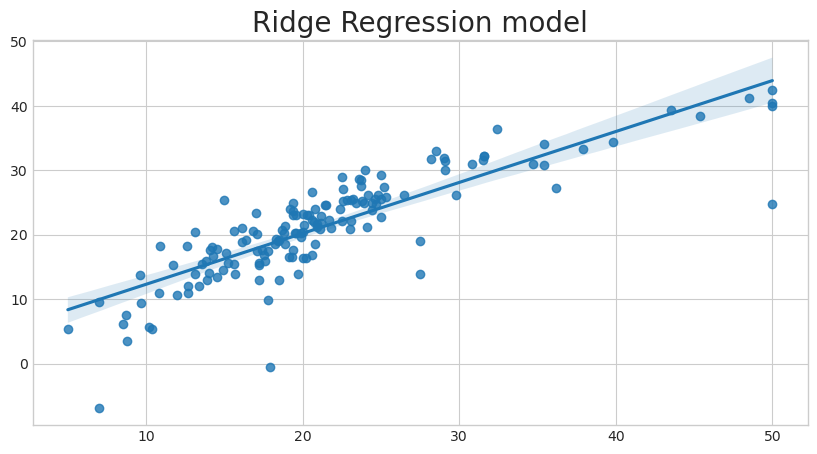

In [38]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Ridge Regression model', fontsize = 20)

#### 12.3 Lasso Regression

In [39]:
from sklearn.linear_model import Lasso

# Creating and training model
lasso_reg = Lasso(alpha=0.2)
lasso_reg.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = lasso_reg.predict(X_test)

In [40]:
# Predicting Cross Validation Score
cv_lasso = cross_val_score(estimator = lasso_reg, X = X_train, y = y_train, cv = 10)

# Calculating Adjusted R-squared
r2 = lasso_reg.score(X_test, y_test)
# Number of observations is the shape along axis 0
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# Adjusted R-squared formula
lasso_adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
lasso_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
lasso_R2 = lasso_reg.score(X_test, y_test)
lassoCV_R2 = cv_lasso.mean()

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),4) )
print('R2:', round( lasso_reg.score(X_test, y_test),4) )
print('Adjusted R2:', round( lasso_adjusted_r2,4) )
print("Cross Validated R2:", round( cv_lasso.mean(),4) )

RMSE: 4.877
R2: 0.6808
Adjusted R2: 0.6507
Cross Validated R2: 0.674


Text(0.5, 1.0, 'Lasso Regression model')

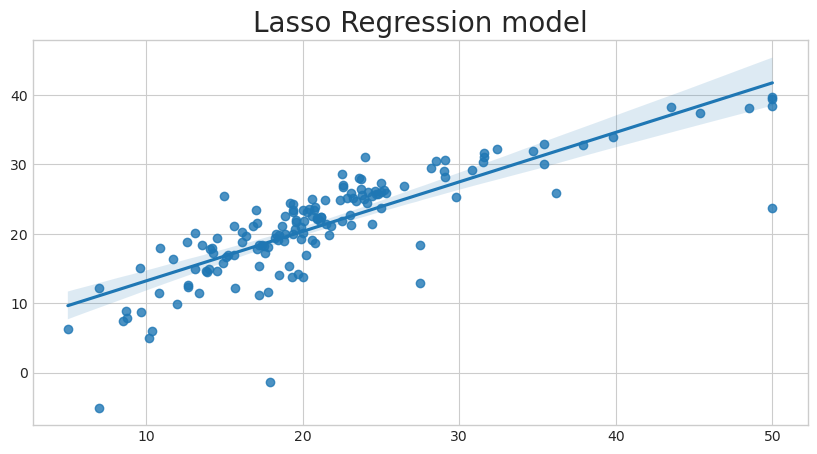

In [41]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Lasso Regression model', fontsize = 20)

#### 12.4 Bayesian Ridge Regression

In [42]:
from sklearn.linear_model import BayesianRidge

# Creating and training model
BayesianRidge_reg = BayesianRidge()
BayesianRidge_reg.fit(X_train, y_train)
   
# Model making a prediction on test data
y_pred = BayesianRidge_reg.predict(X_test)

In [43]:
# Predicting Cross Validation Score
cv_BayesianRidge = cross_val_score(estimator = BayesianRidge_reg, X = X_train, y = y_train, cv = 10)

# Calculating Adjusted R-squared
r2 = BayesianRidge_reg.score(X_test, y_test)
# Number of observations is the shape along axis 0
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]

# Adjusted R-squared formula
BayesianRidge_adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
BayesianRidge_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
BayesianRidge_R2 = BayesianRidge_reg.score(X_test, y_test)
BayesianRidgeCV_R2 = cv_BayesianRidge.mean()

print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),6) )
print('R2:', round( BayesianRidge_reg.score(X_test, y_test),6) )
print('Adjusted R2:', round( BayesianRidge_adjusted_r2,6) )
print("Cross Validated R2:", round( cv_BayesianRidge.mean(),6) )

RMSE: 4.64904
R2: 0.709936
Adjusted R2: 0.682611
Cross Validated R2: 0.689958


Text(0.5, 1.0, 'Bayesian Ridge Regression model')

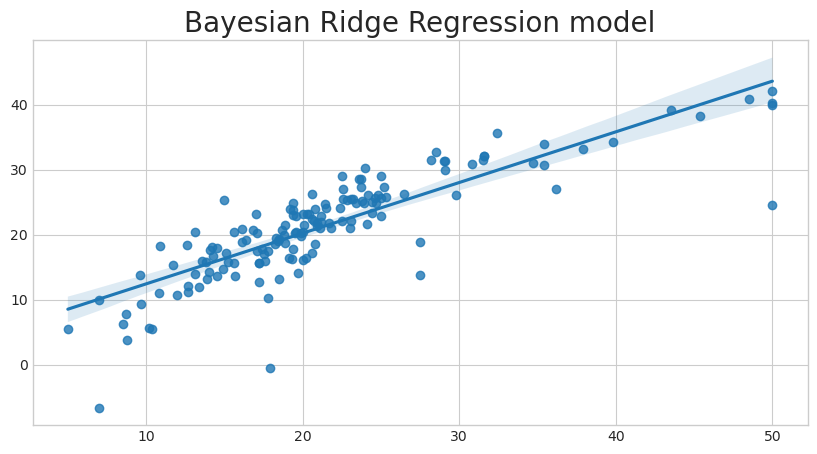

In [44]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Bayesian Ridge Regression model', fontsize = 20)

### 13. Model Evaluation   
#### 13.1 Creating new dataframe

In [45]:
models = [('Linear Regression', lm_RMSE, lm_R2, lm_adjusted_r2, lmCV_R2),
          ('Random Forest Regressor', rf_RMSE, rf_R2, rf_adjusted_r2, rfCV_R2),
          ('Linear Regression VIF', lm2_RMSE, lm2_R2, lm2_adjusted_r2, lm2CV_R2),
          ('Random Forest Regressor VIF', rf2_RMSE, rf2_R2, rf2_adjusted_r2, rf2CV_R2),
          ('Random Forest Regressor RFE', rf_pipeline_RMSE, rf_pipeline_R2, rf_pipeline_adjusted_r2, rf_pipelineCV_R2),
          ('Ridge Regression', lasso_RMSE, lasso_R2, lasso_adjusted_r2, lassoCV_R2),
          ('Lasso Regression', ridge_RMSE, ridge_R2, ridge_adjusted_r2, ridgeCV_R2),
          ('Bayesian Ridge Regression', BayesianRidge_RMSE, BayesianRidge_R2, BayesianRidge_adjusted_r2, BayesianRidgeCV_R2),   
         ]

In [46]:
predictions = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2 Score', 'Adjusted R2 Score', 'Cross Validated R2 Score'])
predictions

,Model,RMSE,R2 Score,Adjusted R2 Score,Cross Validated R2 Score
0,Linear Regression,4.638690,0.711226,0.684023,0.687535
1,Random Forest Regressor,3.329100,0.851262,0.837251,0.817071
2,Linear Regression VIF,5.457282,0.600313,0.580884,0.606042
3,Random Forest Regressor VIF,4.406752,0.739382,0.726713,0.755377
4,Random Forest Regressor RFE,4.392726,0.741038,0.728450,0.767713
5,Ridge Regression,4.876996,0.680793,0.650723,0.673983
6,Lasso Regression,4.640288,0.711027,0.683805,0.688212
7,Bayesian Ridge Regression,4.649040,0.709936,0.682611,0.689958


결과는 조금 놀랍습니다.

- VIF 방법을 사용한 단순한 특징 삭제가 더 나쁜 결과를 가져온 것처럼 보입니다!
- 심지어 더 강력한 모델도 가장 단순한 선형 회귀보다 더 나은 결과를 얻지 못했습니다.

결론은 무엇일까요?

- VIF는 우리가 기대하는 것만큼 간단하지 않습니다.
- "더 나은" 모델이 항상 더 나은 것은 아닙니다.
- 아마도 더 나은 결과를 얻으려면 훨씬 더 많은 작업을 해야 할 것입니다(예: 매개변수 튜닝 등).

#### 13.2 Visualizing Model Performance

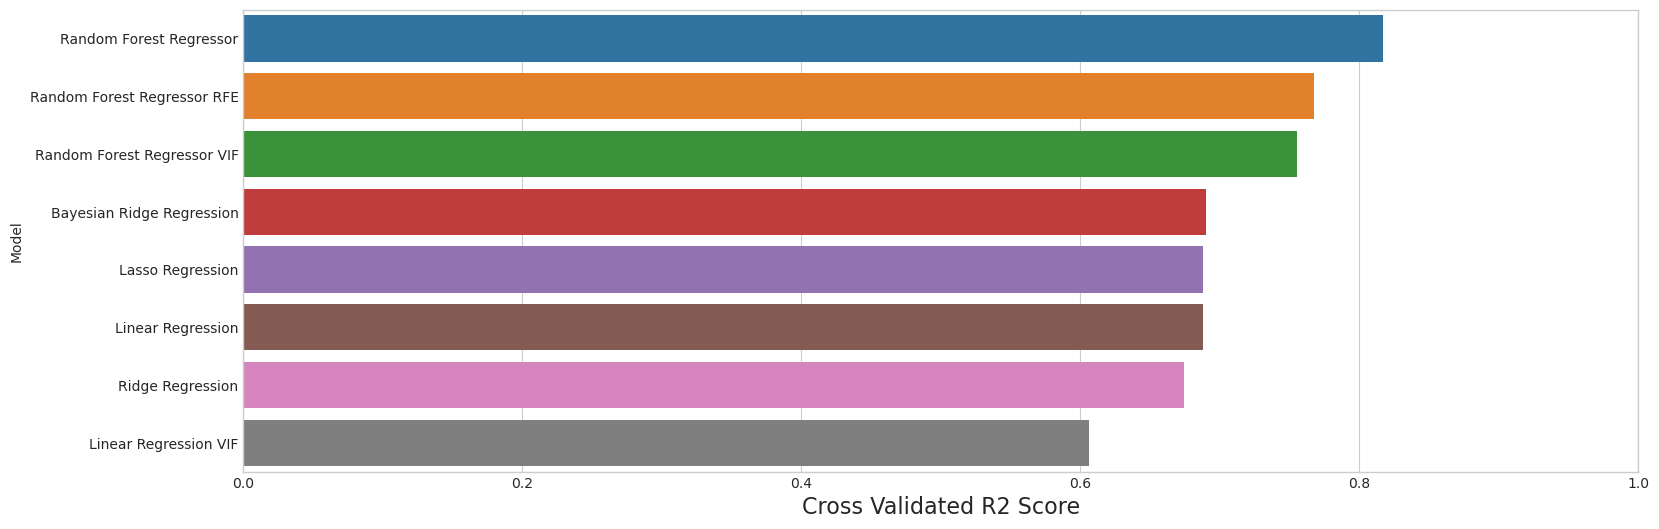

In [47]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predictions.sort_values(by=['Cross Validated R2 Score'], ascending=False, inplace=True)

sns.barplot(x='Cross Validated R2 Score', y='Model', data = predictions, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross Validated R2 Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()